In [1]:
import sys
sys.path.insert(1, '/home/samuel/EFARS/')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import random

from models.openpose import OpenPose
from models.unipose import UniPose
from data.human36m import Human36M2DPoseDataset, Human36MMetadata
from utils.transform import do_pos2d_train_transforms, do_pos2d_val_transforms, denormalize
from utils.misc import AverageMeter, seed_everything
from utils.visualization import show_img_with_hmap, show_hmap_with_pos2d

/home/samuel/anaconda3/envs/pose/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_everything(2333)

root_path = '/home/samuel/h36m'
img_path = root_path + '/imgs'
pos2d_path = root_path + '/pos2d'

img_fns = glob(img_path+'/*.jpg')
random.shuffle(img_fns)
test_fns = img_fns[12000:14000]

In [3]:
test_dataset = Human36M2DPoseDataset(test_fns, pos2d_path, transforms=do_pos2d_train_transforms, mode='E', sigma=7)

In [4]:
from collections import OrderedDict
net = UniPose(dataset='human3.6m',num_classes=17)
#net = OpenPose()
checkpoint = torch.load('/home/samuel/EFARS/estimator/checkpoints/UniPose-20-1e-2/best-checkpoint-003epoch.bin', map_location=torch.device('cpu'))
state_dict = checkpoint['model_state_dict']
new_sd = OrderedDict()
for k, v in state_dict.items():
    new_sd[k[7:]] = v
net.load_state_dict(new_sd)
net.eval()

UniPose(
  (pool_center): AvgPool2d(kernel_size=9, stride=8, padding=1)
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu):

In [5]:
den = lambda img: denormalize(img, Human36MMetadata.mean, Human36MMetadata.std)

In [6]:
img, hmap, skeleton = test_dataset[888]
img = img.unsqueeze(0)
pred = net(img)
pred = pred.squeeze().detach().numpy()
img = img.squeeze().detach()
skeleton = skeleton.squeeze().numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
show_hmap_with_pos2d(pred, [1000,1000])

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
show_hmap_with_pos2d(hmap, [1000,1000], skeleton)

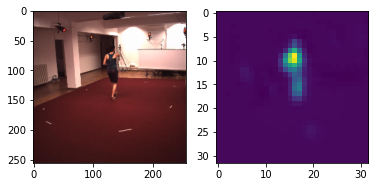

In [7]:
#pred[pred < 0.01] = 0
show_img_with_hmap(img, pred, den)

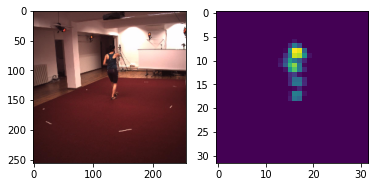

In [7]:
show_img_with_hmap(img, hmap, den)

In [8]:
np.square(hmap - pred).sum()

tensor(0.0036, dtype=torch.float64)

In [9]:
from utils.misc import accuracy
acc, acc_PCK, acc_PCKh, cnt, pred, visible = accuracy(pred.unsqueeze(0).numpy(), hmap.unsqueeze(0).cpu().numpy(), 0.2, 0.5)

In [10]:
print(f'Acc: {acc.mean()}, PCK: {acc_PCK.mean()}, PCKh: {acc_PCKh.mean()}')

Acc: 0.31141868512110726, PCK: 0.6885813148788928, PCKh: 0.31141868512110726
